Author: Haotian Tan  
Final Checked by Oct. 8th, 2025

In [4]:
import pandas as pd

df_0 = pd.read_csv("merged_all_models_T0.csv")
df_1 = pd.read_csv("merged_all_models_T1.csv")

df_0["condition"] = "T0"
df_1["condition"] = "T1"

cols = [
    "id", "group", "amount_of_allocation", "amount_of_cost", "choice",
    "AA_valence", "AA_arousal", "AC_valence", "AC_arousal", "condition"
]

df_all = pd.concat([df_0[cols], df_1[cols]], ignore_index=True)

In [5]:
cols = ["AA_valence", "AA_arousal", "AC_valence", "AC_arousal"]

before = len(df_all)

invalid = df_all[
    (~df_all['choice'].isin([0, 1])) | 
    (df_all[cols] < -100).any(axis=1) | 
    (df_all[cols] > 100).any(axis=1)
]

df_all = df_all[
    df_all['choice'].isin([0, 1]) &
    (df_all[cols] >= -100).all(axis=1) &
    (df_all[cols] <= 100).all(axis=1)
]

after = len(df_all)

removed = before - after
print(f" invalid results: {removed}")

 invalid results: 52


# Paired T-Test between Persona and No persona

supplementary table 7.1.1

In [6]:
import pandas as pd
from scipy.stats import ttest_rel

paired_vars = [
    "choice",
    "AA_valence", "AA_arousal", 
    "AC_valence", "AC_arousal"
]

llm_groups = ['DeepSeek-V3','DeepSeek-R1']
df_llm = df_all[df_all['group'].isin(llm_groups)]

df_agg = df_llm.groupby(['group', 'id', 'condition'])[paired_vars].mean().reset_index()

results = []

for grp in llm_groups:
    df_grp = df_agg[df_agg['group'] == grp]
    
    df_pivot = df_grp.pivot(index='id', columns='condition', values=paired_vars)
    
    for var in paired_vars:
        t1 = df_pivot[var]['T1']
        t0 = df_pivot[var]['T0']
        
        mean_t1, sd_t1 = t1.mean(), t1.std()
        mean_t0, sd_t0 = t0.mean(), t0.std()
        
        t_stat, p_val = ttest_rel(t1, t0)
        
        dfree = len(t1) - 1
        
        results.append({
            'group': grp,
            'variable': var,
            'mean_T1': round(mean_t1, 2),
            'sd_T1': round(sd_t1, 2),
            'mean_T0': round(mean_t0, 2),
            'sd_T0': round(sd_t0, 2),
            't_stat': round(t_stat, 2),
            'df': dfree,
            'p_value': p_val,
            'significance': '***' if p_val<0.001 else '**' if p_val<0.01 else '*' if p_val<0.05 else ''
        })

df_results = pd.DataFrame(results)


df_ttest = pd.DataFrame(results)
df_ttest['p_value'] = df_ttest['p_value'].apply(lambda x: f"{x:.2e}")
df_ttest['t_stat'] = df_ttest['t_stat'].apply(lambda x: f"{x:.2f}")

print(df_ttest.to_string())


         group    variable  mean_T1  sd_T1  mean_T0  sd_T0  t_stat    df    p_value significance
0  DeepSeek-V3      choice     0.82   0.03     0.81   0.03   11.40  1016   2.05e-28          ***
1  DeepSeek-V3  AA_valence    -8.97   3.50    -9.39   3.61   10.73  1016   1.66e-25          ***
2  DeepSeek-V3  AA_arousal    31.09   3.26    32.08   3.51  -28.58  1016  2.45e-132          ***
3  DeepSeek-V3  AC_valence    22.69   1.95    24.89   2.04  -55.94  1016  1.72e-312          ***
4  DeepSeek-V3  AC_arousal    38.43   2.53    38.70   2.58   -6.85  1016   1.28e-11          ***
5  DeepSeek-R1      choice     0.79   0.11     0.79   0.12    1.96  1016   5.07e-02             
6  DeepSeek-R1  AA_valence   -39.80  13.35   -39.59  13.56   -1.95  1016   5.09e-02             
7  DeepSeek-R1  AA_arousal    48.76  19.44    48.60  19.68    1.21  1016   2.28e-01             
8  DeepSeek-R1  AC_valence    18.74   5.90    18.11   6.01    4.40  1016   1.19e-05          ***
9  DeepSeek-R1  AC_arousal    

# Figure of Descriptive results

In [7]:
import matplotlib.pyplot as plt

required_cols = [
    'AA_valence', 'AC_valence',
    'AA_arousal','AC_arousal',
]
choice_col = 'choice'
allocation_col = 'amount_of_allocation'
cost_col = 'amount_of_cost'
group_col = 'group'
cond_col = 'condition'

conds = ["T1","T0"]

xlabels = [
    "Emotion valence after allocation",
    "Emotion valence after decision ",
    "Emotion arousal after allocation",
    "Emotion arousal after decision",
]

cmap_dict = {"T0":  plt.cm.Blues, "T1":plt.cm.Reds}
colors_hist = {"T0": plt.cm.Blues(0.7), "T1": plt.cm.Reds(0.7)}


supplementary figure 7.1.1

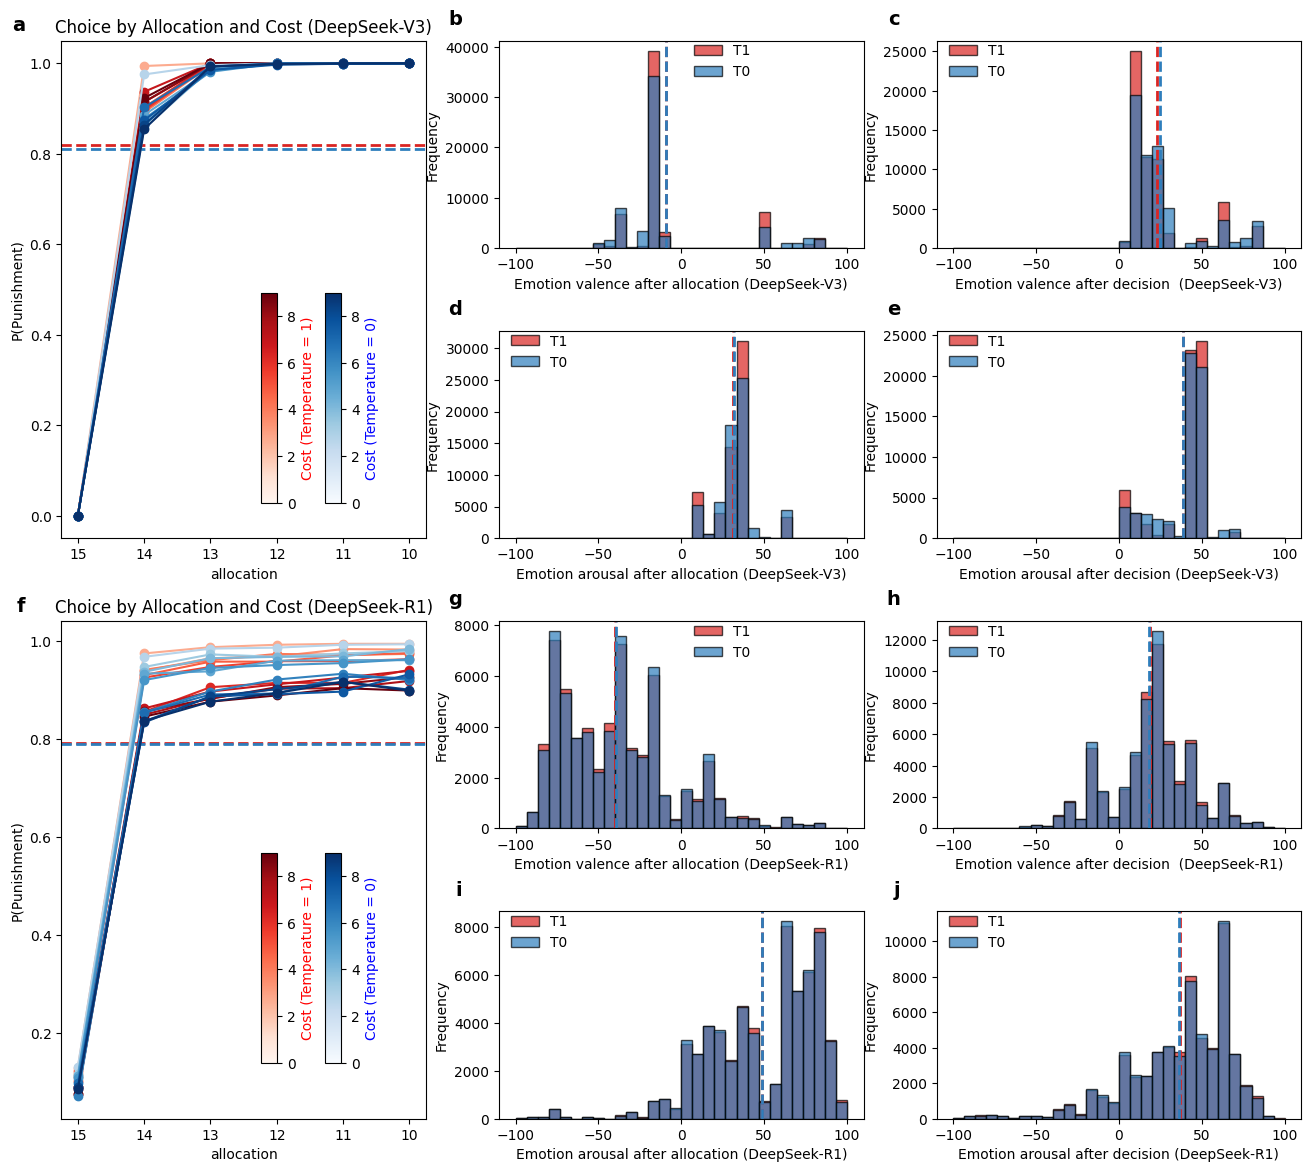

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors

ordered_groups = ['DeepSeek-V3','DeepSeek-R1']
df = df_all[df_all['group'].isin(ordered_groups)].copy()
num_groups = len(ordered_groups)


legend_pos_dict = {
    "DeepSeek-V3": {
        'AA_valence': (0.5, 0.90),
        'AC_valence': (0.0, 0.90),
        'AA_arousal': (0.0, 0.90),
        'AC_arousal': (0.0, 0.90),
    },
    "DeepSeek-R1": {
        'AA_valence': (0.5, 0.90),
        'AC_valence': (0.0, 0.90),
        'AA_arousal': (0.0, 0.90),
        'AC_arousal': (0.0, 0.90),
    }
}

bottoms = [0.55, 0.15]  

fig = plt.figure(figsize=(16, 7*num_groups))
gs = GridSpec(num_groups*2, 3, figure=fig, height_ratios=[1]*2*num_groups, width_ratios=[1,1,1], hspace=0.4)

plot_index = 0

for g_idx, grp in enumerate(ordered_groups):
    df_group = df[df[group_col] == grp]
    legend_pos = legend_pos_dict[grp]

    # figure of choice 
    ax_choice = fig.add_subplot(gs[g_idx*2:g_idx*2+2, 0])
    alloc_values = sorted(df_group[allocation_col].unique(), reverse=True)
    norm_dict = {}
    choice_mean = []

    actual_conds = df_group[cond_col].dropna().unique()
    ordered_conds = [c for c in ['T1','T0'] if c in actual_conds]

    for cond in ordered_conds:
        df_cond = df_group[df_group[cond_col] == cond]
        cost_values = sorted(df_cond[cost_col].unique())
        if not cost_values:
            continue

        norm = mcolors.Normalize(vmin=min(cost_values), vmax=max(cost_values))
        norm_dict[cond] = norm
        cmap = cmap_dict[cond]

        for cost_val in cost_values:
            df_subset = df_cond[df_cond[cost_col] == cost_val]
            means = [df_subset[df_subset[allocation_col]==alloc][choice_col].mean()
                     for alloc in alloc_values]
            mapped_val = norm(cost_val)
            color = cmap(0.3 + 0.7 * mapped_val)
            ax_choice.errorbar([str(a) for a in alloc_values], means,
                               fmt='-o', capsize=4, color=color)

        mean = df_cond[choice_col].mean()
        choice_mean.append(mean)
        ax_choice.axhline(mean, color=colors_hist[cond], linestyle='--', linewidth=2)

    ax_choice.set_xlabel('allocation')
    ax_choice.set_ylabel('P(Punishment)')
    ax_choice.set_title(f'Choice by Allocation and Cost ({grp})')
    ax_choice.set_xticks(range(len(alloc_values)))
    ax_choice.set_xticklabels([str(a) for a in alloc_values])
    ax_choice.text(-0.1, 1.05, f'{chr(97 + plot_index)}',
                   transform=ax_choice.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
    plot_index += 1

    # colorbars
    for i, cond in enumerate(ordered_conds):
        cax = fig.add_axes([0.25 + i*0.04, bottoms[g_idx], 0.01, 0.15])
        sm = plt.cm.ScalarMappable(cmap=cmap_dict[cond], norm=norm_dict[cond])
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cax)
        cbar.set_label(label = "Cost (Temperature = 1)" if cond =="T1" else "Cost (Temperature = 0)", 
                       color='red' if cond=="T1" else 'blue')

    # figure of emotion
    axes = []
    for i in range(4):
        r = g_idx*2 + i//2   
        c = 1 + i%2           
        ax = fig.add_subplot(gs[r, c])
        axes.append(ax)

    for ax, col, xlabel in zip(axes, required_cols, xlabels):
        bins_fixed = np.linspace(-100, 100, 31)
        for cond in ordered_conds:
            df_cond = df_group[df_group[cond_col] == cond]
            if col not in df_cond.columns or df_cond[col].dropna().empty:
                continue
            ax.hist(df_cond[col].dropna(), bins=bins_fixed, alpha=0.7,
                    edgecolor='black', color=colors_hist[cond], label=f'{cond}')
            ax.axvline(df_cond[col].mean(), color=colors_hist[cond], linestyle='--', linewidth=2)

        ax.set_xlabel(f"{xlabel} ({grp})")
        ax.set_ylabel('Frequency')
        lx, ly = legend_pos.get(col, (0.5, 0.9))
        ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(lx, ly), frameon=False)
        ax.text(-0.1, 1.15, f'{chr(97 + plot_index)}',
                transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
        plot_index += 1

fig.savefig(f"Descriptive_LLMs.svg", format="svg", bbox_inches="tight")
plt.show()


# Emotional results by choice

supplementary table 7.1.2

In [10]:
df_avg = df_all.groupby(["id", "group", "condition", "choice"], as_index=False)[
    ["AA_valence", "AA_arousal", "AC_valence", "AC_arousal"]
].mean()

summary = df_avg.groupby(["group", "condition", "choice"])[
    ["AA_valence", "AA_arousal", "AC_valence", "AC_arousal"]
].agg(["mean", "std"]).reset_index()

summary.columns = ["_".join(col).strip("_") if isinstance(col, tuple) else col for col in summary.columns.values]

for measure in ["AA_valence", "AA_arousal", "AC_valence", "AC_arousal"]:
    summary[measure] = summary.apply(
        lambda row: f"{row[f'{measure}_mean']:.2f} ({row[f'{measure}_std']:.2f})", axis=1
    )
    summary = summary.drop([f"{measure}_mean", f"{measure}_std"], axis=1)

summary = summary.sort_values(["group", "condition", "choice"])

summary.to_csv("summary_mean_std.csv", index=False)
print(summary.to_string())

          group condition  choice      AA_valence     AA_arousal     AC_valence     AC_arousal
0   DeepSeek-R1        T0       0   13.66 (15.35)  12.49 (15.45)  28.12 (12.96)  -2.33 (10.50)
1   DeepSeek-R1        T0       1  -51.03 (14.36)  57.02 (18.68)   16.56 (6.10)   46.26 (9.56)
2   DeepSeek-R1        T1       0   13.79 (15.23)  12.06 (15.63)  28.51 (13.22)  -2.67 (10.70)
3   DeepSeek-R1        T1       1  -51.32 (13.91)  57.29 (18.31)   17.25 (5.89)   46.46 (9.11)
4   DeepSeek-V3        T0       0   55.74 (10.93)   17.31 (2.53)   63.17 (9.51)   11.17 (1.93)
5   DeepSeek-V3        T0       1   -24.10 (3.63)   35.42 (3.97)   16.26 (1.68)   45.05 (2.32)
6   DeepSeek-V3        T1       0   54.20 (11.04)   13.76 (2.32)  61.96 (10.12)    8.38 (1.75)
7   DeepSeek-V3        T1       1   -22.58 (3.39)   34.84 (3.70)   14.27 (1.42)   45.02 (2.47)
8       GPT-3.5        T1       0   -34.45 (8.83)   20.95 (3.78)   -9.44 (6.13)   15.78 (3.83)
9       GPT-3.5        T1       1   -43.98 (3.75) 

# Merged subplot of Emotional results by choice

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(2, 6))  
ax.axis('off')
ax.set_xlim(0.8, 1)
ax.set_ylim(0, 1)

# accept block
accept_x0, accept_x1 = 0.82, 0.88
accept_y0, accept_y1 = 0.1, 0.45
accept_w = accept_x1 - accept_x0
accept_h = accept_y1 - accept_y0
ax.add_patch(Rectangle((accept_x0, accept_y0), accept_w, accept_h, facecolor="#00BFC4"))
ax.text(accept_x0 + 0.09, (accept_y0 + accept_y1)/2, "accept", ha="center", va="center", rotation=90, fontsize=16)

# punish block
punish_x0, punish_x1 = 0.82, 0.88
punish_y0, punish_y1 = 0.55, 0.9
punish_w = punish_x1 - punish_x0
punish_h = punish_y1 - punish_y0
ax.add_patch(Rectangle((punish_x0, punish_y0), punish_w, punish_h, facecolor="#F8766D"))
ax.text(punish_x0 + 0.09, (punish_y0 + punish_y1)/2, "punish", ha="center", va="center", rotation=90, fontsize=16)

plt.savefig("legend.svg", bbox_inches='tight', pad_inches=0)
plt.close()

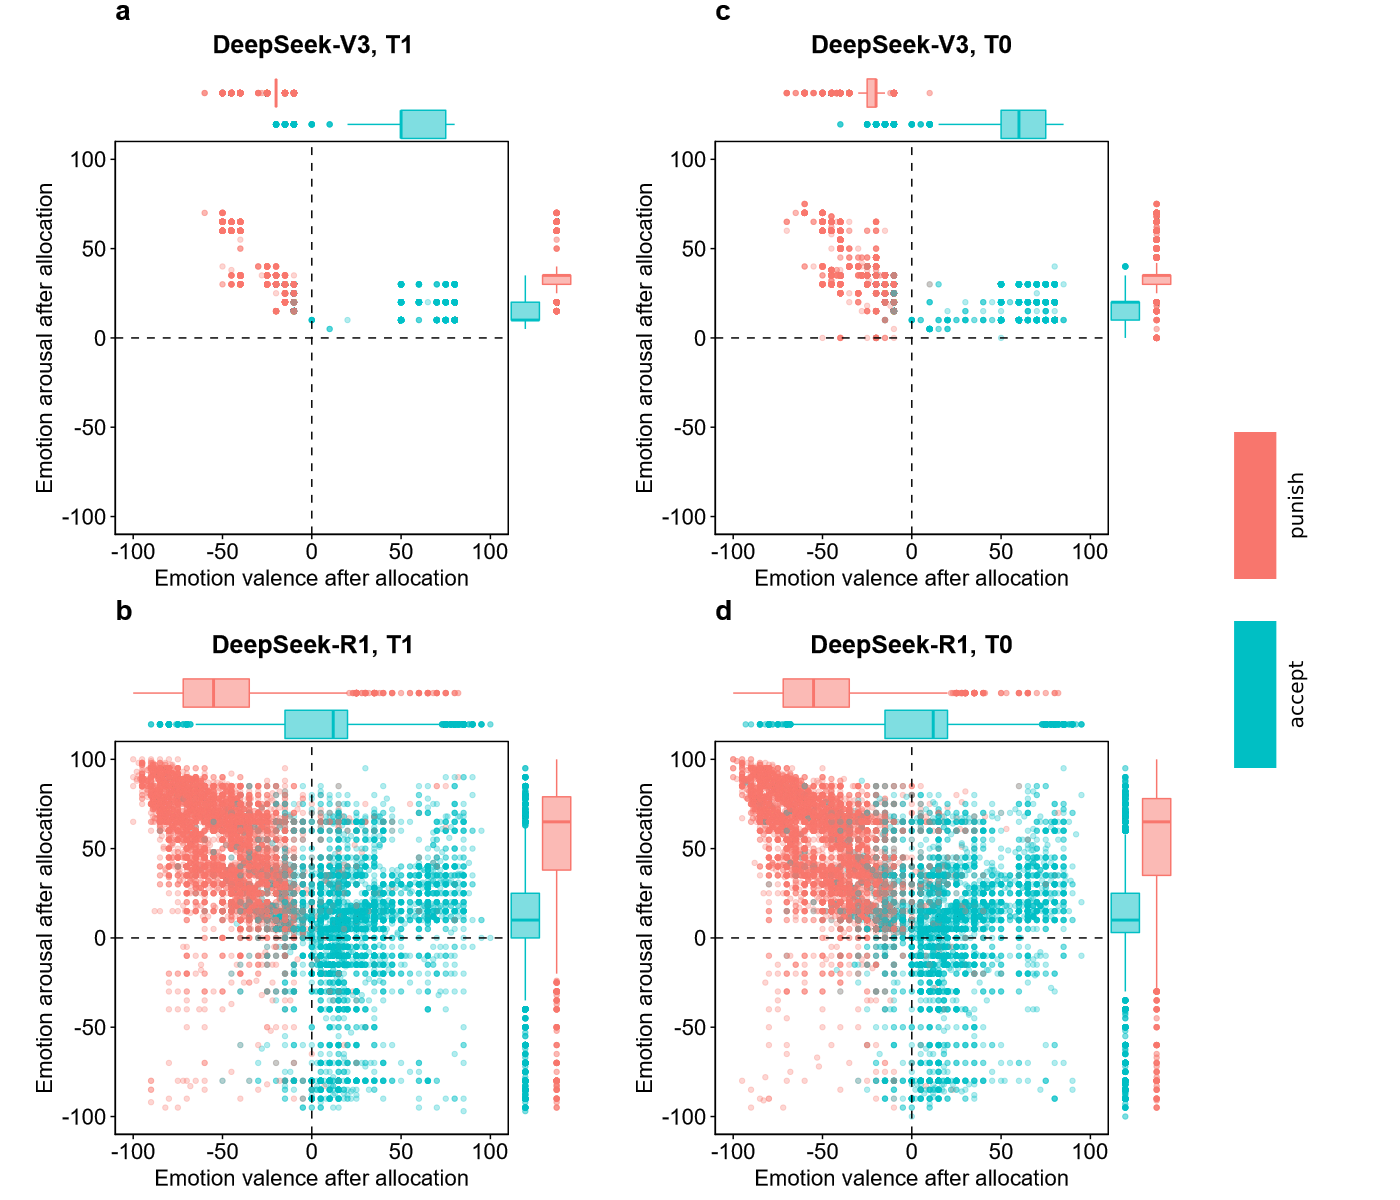

In [14]:
from lxml import etree
import cairosvg
from IPython.display import Image, display

svg_files = {
    "legend": "legend.svg",
    "llms": "fig_aae_choice_llm.svg"
}

fig_width_px = 1400
fig_height_px = 1200

NSMAP = {None: "http://www.w3.org/2000/svg"}
svg_root = etree.Element("svg", nsmap=NSMAP)
svg_root.set("width", f"{fig_width_px}px")
svg_root.set("height", f"{fig_height_px}px")
svg_root.set("version", "1.1")


bg = etree.Element("rect", x="0", y="0", width=str(fig_width_px), height=str(fig_height_px), fill="white")
svg_root.append(bg)

legend_svg = etree.parse(svg_files["legend"]).getroot()
legend_w = float(legend_svg.get("width").replace("px", "").replace("pt", ""))
legend_h = float(legend_svg.get("height").replace("px", "").replace("pt", ""))

llms_svg = etree.parse(svg_files["llms"]).getroot()
llms_w = float(llms_svg.get("width").replace("px", "").replace("pt", ""))
llms_h = float(llms_svg.get("height").replace("px", "").replace("pt", ""))

legend_height_ratio = 0.35
target_h_legend = fig_height_px * legend_height_ratio
scale_legend = target_h_legend / legend_h
legend_final_w = legend_w * scale_legend

x_offset_legend = llms_w * (fig_height_px / llms_h) + 20  
y_offset_legend = (fig_height_px - legend_h * scale_legend) / 2 

g_legend = etree.Element("g")
g_legend.set("transform", f"translate({x_offset_legend},{y_offset_legend}) scale({scale_legend})")
for child in legend_svg:
    g_legend.append(child)
svg_root.append(g_legend)


scale_llms = fig_height_px / llms_h
g_llms = etree.Element("g")
g_llms.set("transform", f"translate(0,0) scale({scale_llms})")
for child in llms_svg:
    g_llms.append(child)
svg_root.append(g_llms)


tree_out = etree.ElementTree(svg_root)
tree_out.write("Fig_aae_choice.svg", encoding="utf-8", xml_declaration=True)
cairosvg.svg2png(url="Fig_aae_choice.svg", write_to="Fig_aae_choice.png")

display(Image(filename="Fig_aae_choice.png"))

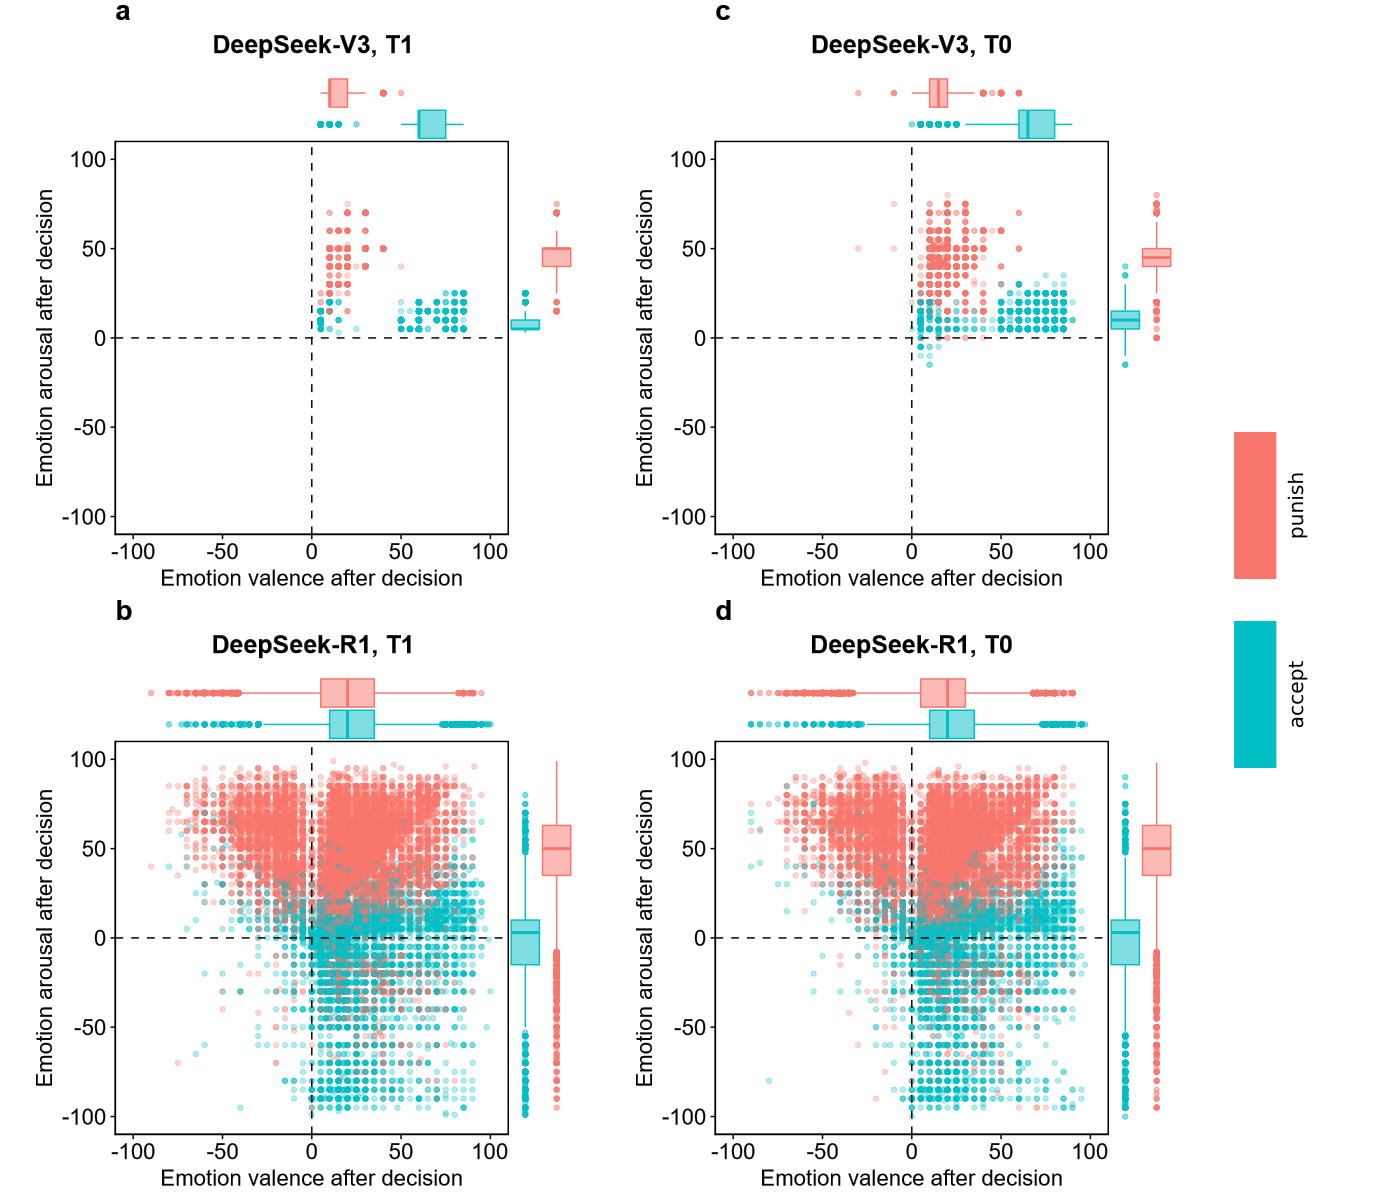

In [15]:
from lxml import etree
import cairosvg
from IPython.display import Image, display

svg_files = {
    "legend": "legend.svg",
    "llms": "fig_ace_choice_llm.svg"
}

fig_width_px = 1400
fig_height_px = 1200

NSMAP = {None: "http://www.w3.org/2000/svg"}
svg_root = etree.Element("svg", nsmap=NSMAP)
svg_root.set("width", f"{fig_width_px}px")
svg_root.set("height", f"{fig_height_px}px")
svg_root.set("version", "1.1")


bg = etree.Element("rect", x="0", y="0", width=str(fig_width_px), height=str(fig_height_px), fill="white")
svg_root.append(bg)

legend_svg = etree.parse(svg_files["legend"]).getroot()
legend_w = float(legend_svg.get("width").replace("px", "").replace("pt", ""))
legend_h = float(legend_svg.get("height").replace("px", "").replace("pt", ""))

llms_svg = etree.parse(svg_files["llms"]).getroot()
llms_w = float(llms_svg.get("width").replace("px", "").replace("pt", ""))
llms_h = float(llms_svg.get("height").replace("px", "").replace("pt", ""))

legend_height_ratio = 0.35
target_h_legend = fig_height_px * legend_height_ratio
scale_legend = target_h_legend / legend_h
legend_final_w = legend_w * scale_legend

x_offset_legend = llms_w * (fig_height_px / llms_h) + 20  
y_offset_legend = (fig_height_px - legend_h * scale_legend) / 2 

g_legend = etree.Element("g")
g_legend.set("transform", f"translate({x_offset_legend},{y_offset_legend}) scale({scale_legend})")
for child in legend_svg:
    g_legend.append(child)
svg_root.append(g_legend)


scale_llms = fig_height_px / llms_h
g_llms = etree.Element("g")
g_llms.set("transform", f"translate(0,0) scale({scale_llms})")
for child in llms_svg:
    g_llms.append(child)
svg_root.append(g_llms)


tree_out = etree.ElementTree(svg_root)
tree_out.write("Fig_ace_choice.svg", encoding="utf-8", xml_declaration=True)
cairosvg.svg2png(url="Fig_ace_choice.svg", write_to="Fig_ace_choice.png")

display(Image(filename="Fig_ace_choice.png"))